In [ ]:
import sys
sys.path.append('../../activedrops')
import autocorrelation

import pandas as pd
import numpy as np
from scipy.signal import correlate2d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [ ]:
def load_and_convert_data(file_path):
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    
    # Convert position and velocity to microns and microns/second
    df['x [um]'] = df['x [m]'] * 1E6
    df['y [um]'] = df['y [m]'] * 1E6
    df['u [um/s]'] = df['u [m/s]'] * 1E6
    df['v [um/s]'] = df['v [m/s]'] * 1E6
    
    # Replace NaN values with 0s
    df = df.fillna(0)
    
    # Drop the original columns and retain only the converted ones
    df = df[['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]']]
    
    return df

# Load the data using the updated function
data_0001 = load_and_convert_data("../../data/k401bio-250nM-piv/PIVlab_0001.txt")
data_0001.head()


In [ ]:
# Spatial autocorrelation functions from the notebook
def compute_full_product(data):
    return np.fft.fft2(data) * np.conj(np.fft.fft2(data))

def direct_spatial_autocorrelation_from_full_product(full_product, shape, r):
    inverse = np.real(np.fft.ifft2(full_product))
    return (inverse[r, r] + inverse[-r, -r]) / (shape[0] * shape[1])

def compute_autocorrelation_for_one_time_simple(tt, UX, UY, r_values):
    magnitude = np.sqrt(UX**2 + UY**2)
    full_product = compute_full_product(magnitude)
    results = [direct_spatial_autocorrelation_from_full_product(full_product, magnitude.shape, r) for r in r_values]
    return tt, results

def compute_autocorrelation(velocity_data):
    r_values = list(range(1, 50))
    results = {}
    
    for tt, (UX, UY) in velocity_data.items():
        _, autocorr_values = compute_autocorrelation_for_one_time_simple(tt, UX, UY, r_values)
        results[tt] = autocorr_values
        
    return results


In [ ]:
# Extracting the u and v velocities
UX = data_0001['u [um/s]'].values.reshape(-1, int(data_0001['x [um]'].nunique()))
UY = data_0001['v [um/s]'].values.reshape(-1, int(data_0001['x [um]'].nunique()))

# Since we only have one frame, we'll use a dictionary with a single time point (e.g., t=0) 
# and the corresponding velocity arrays.
velocity_data = {0: (UX, UY)}

# Recompute spatial autocorrelation
direct_results_zero_filled = compute_autocorrelation(velocity_data)

In [ ]:
import matplotlib.pyplot as plt

# Extract autocorrelation results
r_values = list(range(1, 50))
autocorrelation_values = direct_results_zero_filled[0]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(r_values, autocorrelation_values, label="Spatial Autocorrelation", marker='o')
plt.xlabel('Spatial Lag (r)')
plt.ylabel('Autocorrelation')
plt.title('Spatial Autocorrelation for Frame PIVlab_0001')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Determine the correlation length based on the 1/e threshold
initial_value = direct_results_zero_filled[0][0]
correlation_threshold = initial_value / np.e

# Find the spatial lag where the autocorrelation drops to (or below) the threshold
correlation_length = next((r for r, value in zip(r_values, direct_results_zero_filled[0]) if value <= correlation_threshold), None)

correlation_length


In [ ]:
from scipy.optimize import curve_fit

# Define the exponential decay function
def exponential_decay(r, A, xi, C):
    return A * np.exp(-r / xi) + C

# Fit the spatial autocorrelation data
params, covariance = curve_fit(exponential_decay, r_values, direct_results_zero_filled[0], p0=[1, 20, 0])

# Extract the correlation length (xi) from the fitted parameters
A_fit, xi_fit, C_fit = params

xi_fit


In [ ]:
# Generate informed initial guesses

# Amplitude (A) - First value of the autocorrelation data
A_guess = direct_results_zero_filled[0][0]

# Offset (C) - Average of the last few values of the autocorrelation data
C_guess = np.mean(direct_results_zero_filled[0][-5:])

# Correlation Length (xi) - Spatial lag where autocorrelation is half of its initial value
xi_guess = next((r for r, value in zip(r_values, direct_results_zero_filled[0]) if value <= A_guess / 2), 20)  # Default to 20 if not found

# Use the generated guesses for curve fitting
params_informed, covariance_informed = curve_fit(exponential_decay, r_values, direct_results_zero_filled[0], p0=[A_guess, xi_guess, C_guess])
A_fit_informed, xi_fit_informed, C_fit_informed = params_informed

A_guess, xi_guess, C_guess, xi_fit_informed


In [ ]:
# Recalculate the fitted values for visualization
fitted_values = exponential_decay(np.array(r_values), A_fit_informed, xi_fit_informed, C_fit_informed)

# Re-plot the original and fitted autocorrelation data
plt.figure(figsize=(10, 6))
plt.plot(r_values, direct_results_zero_filled[0], 'o', label="Original Data", markersize=4)
plt.plot(r_values, fitted_values, '--', label="Exponential Fit")
plt.axvline(xi_fit_informed, color='red', linestyle='--', label=f"Correlation Length (ξ) = {xi_fit:.2f}")
plt.xlabel('Spatial Lag (r)')
plt.ylabel('Autocorrelation')
plt.title('Spatial Autocorrelation with Exponential Fit')
plt.legend()
plt.grid(True)
plt.show()


Now multiple frames

In [1]:
import sys
sys.path.append('../../activedrops')
import autocorrelation

import pandas as pd
import numpy as np
from scipy.signal import correlate2d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [2]:
def load_and_convert_data(file_path):
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    
    # Convert position and velocity to microns and microns/second
    df['x [um]'] = df['x [m]'] * 1E6
    df['y [um]'] = df['y [m]'] * 1E6
    df['u [um/s]'] = df['u [m/s]'] * 1E6
    df['v [um/s]'] = df['v [m/s]'] * 1E6
    
    # Replace NaN values with 0s
    df = df.fillna(0)
    
    # Drop the original columns and retain only the converted ones
    df = df[['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]']]
    
    return df



In [3]:
def process_multiple_frames_updated(file_paths, r_values):
    """
    Process multiple frames to compute their spatial autocorrelation.
    
    Parameters:
    - file_paths: List of file paths for each frame.
    - r_values: List of spatial lags for which autocorrelation should be computed.
    
    Returns:
    - Dictionary with keys as frame number and values as computed autocorrelation.
    """
    results = {}
    
    for file_path in file_paths:
        # Load and convert data
        df = load_and_convert_data(file_path)
        
        reshape_dim = int(np.sqrt(df.shape[0]))

        # Extract velocities and reshape
        UX, UY = df['u [um/s]'].values.reshape((reshape_dim, reshape_dim)), df['v [um/s]'].values.reshape((reshape_dim, reshape_dim))
        
        # Compute autocorrelation
        frame_num = int(file_path.split('_')[-1].split('.')[0])  # Extract frame number from file name
        _, autocorr_values = compute_autocorrelation_for_one_time_simple(frame_num, UX, UY, r_values)
        
        results[frame_num] = autocorr_values
        
    return results

# Spatial autocorrelation functions from the notebook
def compute_full_product(data):
    return np.fft.fft2(data) * np.conj(np.fft.fft2(data))

def direct_spatial_autocorrelation_from_full_product(full_product, shape, r):
    inverse = np.real(np.fft.ifft2(full_product))
    return (inverse[r, r] + inverse[-r, -r]) / (shape[0] * shape[1])

def compute_autocorrelation_for_one_time_simple(tt, UX, UY, r_values):
    magnitude = np.sqrt(UX**2 + UY**2)
    full_product = compute_full_product(magnitude)
    results = [direct_spatial_autocorrelation_from_full_product(full_product, magnitude.shape, r) for r in r_values]
    return tt, results

def compute_autocorrelation(velocity_data):
    r_values = list(range(1, 50))
    results = {}
    
    for tt, (UX, UY) in velocity_data.items():
        _, autocorr_values = compute_autocorrelation_for_one_time_simple(tt, UX, UY, r_values)
        results[tt] = autocorr_values
        
    return results

# Define the exponential decay function
def exponential_decay(r, A, xi, C):
    return A * np.exp(-r / xi) + C




In [4]:
# Define the file paths for the frames
file_paths = ["../../data/k401bio-250nM-piv/PIVlab_0001.txt", 
              "../../data/k401bio-250nM-piv/PIVlab_0002.txt", 
              ]

# Define the range of r values for which autocorrelation should be computed
r_values_custom = list(range(1, 50))

# Process the frames using the updated function
results_multiple_frames_updated = process_multiple_frames_updated(file_paths, r_values_custom)
results_multiple_frames_updated

{1: [5.640656423393756,
  5.116072039230089,
  4.822792507522883,
  4.626330474408191,
  4.5531067324704395,
  4.416077494083014,
  4.28087690049526,
  4.151145512491247,
  3.9563952662064974,
  3.8325405683031466,
  3.7414646358499986,
  3.62728892697317,
  3.6050371712244105,
  3.4440804512717094,
  3.263905996387921,
  3.237037121527133,
  3.1501376526655074,
  3.120428698510971,
  3.0345866470083696,
  2.9726360971725088,
  2.9454806400287925,
  2.81975382567714,
  2.7945665391696295,
  2.761435369254211,
  2.7173036109177553,
  2.647467352004944,
  2.5711985688182515,
  2.5401821688039283,
  2.4400485947416386,
  2.3997898116008836,
  2.3982108422435466,
  2.348827572971327,
  2.3187240506165576,
  2.2701874682716716,
  2.2178837862474277,
  2.128352115270064,
  2.027856675512517,
  1.9891861651546439,
  1.9510488046958814,
  1.9266588578309027,
  1.9038349818808553,
  1.8145096632760784,
  1.808187405044808,
  1.7580289185410176,
  1.7519195824508915,
  1.7062652043726345,
  1.68

In [8]:
# Plot the autocorrelation data for all frames along with their respective exponential fits

plt.figure(figsize=(14, 10))

for frame_num in results_multiple_frames_updated.keys():
    autocorr_values = results_multiple_frames_updated[frame_num]
    
    # Informed guesses
    A_guess = autocorr_values[0]
    C_guess = np.mean(autocorr_values[-5:])
    xi_guess = next((r for r, value in zip(r_values_custom, autocorr_values) if value <= A_guess / 2), 20)
    
    # Fit the spatial autocorrelation data with informed guesses
    params_informed, _ = curve_fit(exponential_decay, r_values_custom, autocorr_values, p0=[A_guess, xi_guess, C_guess])
    A_fit, xi_fit, C_fit = params_informed

    # Generate the fitted values for visualization
    fitted_values = exponential_decay(np.array(r_values_custom), A_fit, xi_fit, C_fit)

    # Plot the original and fitted autocorrelation data for the frame
    plt.plot(r_values_custom, autocorr_values, 'o', label=f"Frame {frame_num} Data", markersize=4)
    plt.plot(r_values_custom, fitted_values, '--', label=f"Frame {frame_num} Fit")
    plt.axvline(xi_fit, color='red', linestyle='--', label=f"Correlation Length (ξ) = {xi_fit:.2f}")


plt.xlabel('Spatial Lag (r)')
plt.ylabel('Autocorrelation')
plt.title('Spatial Autocorrelation with Exponential Fit for All Frames')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'results_multiple_frames' is not defined

In [6]:
# Create a list to store results
results_list = []

# Compute the exponential fit parameters and extract the correlation length for each frame
for file_path in file_paths:
    # Extract frame number from file name
    frame_num = int(file_path.split('_')[-1].split('.')[0])
    
    # Load the autocorrelation data
    autocorr_values = results_multiple_frames_updated[frame_num]
    
    # Informed guesses
    A_guess = autocorr_values[0]
    C_guess = np.mean(autocorr_values[-5:])
    xi_guess = next((r for r, value in zip(r_values_custom, autocorr_values) if value <= A_guess / 2), 20)
    
    # Fit the spatial autocorrelation data with informed guesses
    params_informed, _ = curve_fit(exponential_decay, r_values_custom, autocorr_values, p0=[A_guess, xi_guess, C_guess])
    _, xi_fit, _ = params_informed
    
    # Append the results to the list
    results_list.append([frame_num * 3 / 60, f"PIVlab_000{frame_num}.txt", xi_fit])

# Convert the results list to a pandas DataFrame
df_correlation_length = pd.DataFrame(results_list, columns=['Time (min)', 'File Name', 'Correlation Length'])
df_correlation_length


,Time (min),File Name,Correlation Length
0,0.05,PIVlab_0001.txt,22.860318
1,0.10,PIVlab_0002.txt,18.528855
2,0.15,PIVlab_0003.txt,25.848133
3,0.20,PIVlab_0004.txt,24.072502
4,0.20,PIVlab_0004.txt,24.072502


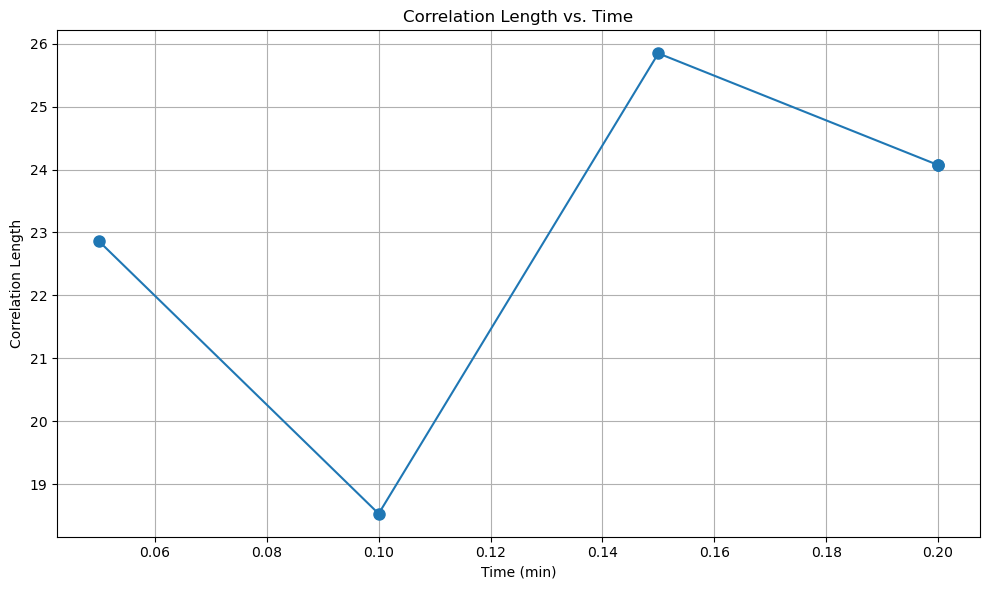

In [7]:
# Plot Correlation Length vs. Time

plt.figure(figsize=(10, 6))
plt.plot(df_correlation_length['Time (min)'], df_correlation_length['Correlation Length'], '-o', markersize=8)
plt.xlabel('Time (min)')
plt.ylabel('Correlation Length')
plt.title('Correlation Length vs. Time')
plt.grid(True)
plt.tight_layout()
plt.show()
